In [26]:
import os,time
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

%matplotlib inline

In [27]:
import torch 
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
from torchvision.utils import save_image

In [28]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5,),std=(0.5,))
])

train_dataset = torchvision.datasets.MNIST(
    root='.',
    train=True,
    transform = transform,
    download=True
)

In [29]:
len(train_dataset)

60000

In [30]:
batch_size = 32
data_loader = torch.utils.data.DataLoader(dataset = train_dataset,
                                         batch_size = batch_size,
                                         shuffle = True)

In [31]:
## Discriminator model
D = nn.Sequential(
    nn.Linear(784,512),
    nn.LeakyReLU(0.2),
    nn.Linear(512,256),
    nn.LeakyReLU(0.2),
    nn.Linear(256,1)
)

latent_dim = 100
G = nn.Sequential(
    nn.Linear(latent_dim,256),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(256,momentum = 0.7),
    nn.Linear(256,512),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(512,momentum = 0.7),
    nn.Linear(512,1024),
    nn.LeakyReLU(0.2),
    nn.BatchNorm1d(1024,momentum = 0.7),
    nn.Linear(1024,784),
    nn.Tanh()
)

In [32]:
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
D = D.to(DEVICE)
G = G.to(DEVICE)

In [33]:
criterion = nn.BCEWithLogitsLoss()
d_optimizer = torch.optim.Adam(D.parameters(),lr = 0.0002)
g_optimizer = torch.optim.Adam(G.parameters(),lr = 0.0002)

def scale_image(img):
    out = (img+1)/2
    return out

In [34]:
if not os.path.exists('gan_images'):
    os.makedirs('gan_images')

In [36]:
#### Training Loop ###

ones_ = torch.ones(batch_size,1).to(DEVICE)
zeros_ = torch.zeros(batch_size,1).to(DEVICE)

d_losses = []
g_losses = []
for epoch in range(200):
    for inputs ,_ in data_loader:
        n = inputs.size(0)
        inputs = inputs.reshape(n,784).to(DEVICE)
        # create targets
        ones = ones_[:n]
        zeros = zeros_[:n]
        
        ## train discriminator
        
        # real images
        real_out = D(inputs)
        real_loss = criterion(real_out,ones)
        
        # noise images
        noise = torch.randn(n,latent_dim).to(DEVICE)
        fake_inputs = G(noise)
        fake_out = D(fake_inputs)
        fake_loss = criterion(fake_out,zeros)
        
        #gradient descent
        d_loss = 0.5*(real_loss + fake_loss)
        d_optimizer.zero_grad()
        g_optimizer.zero_grad()
        d_loss.backward()
        d_optimizer.step()
        
        ## train generator
        
        for _ in range(2):
            noise = torch.randn(n,latent_dim).to(DEVICE)
            fake_image = G(noise)
            fake_out = D(fake_image)
            
            #reverse labels
            g_loss = criterion(fake_out,ones)
            
            #gradient step
            d_optimizer.zero_grad()
            g_optimizer.zero_grad()
            g_loss.backward()
            g_optimizer.step()
            
        d_losses.append(d_loss.item())
        g_losses.append(g_loss.item())
        
    print(f'Epoch : {epoch} , d_loss : {d_loss.item():.4f} , g_loss : {g_loss.item()}')
    fake_images = fake_image.reshape(-1,1,28,28)
    save_image(scale_image(fake_images),f'gan_images/{epoch+1}.png')
    if epoch % 20 == 0:
        torch.save(D.state_dict(),'tmp/d_epoch_{}.pt'.format(epoch))
        torch.save(G.state_dict(),'tmp/g_epoch_{}.pt'.format(epoch))


Epoch : 0 , d_loss : 0.0883 , g_loss : 4.106719970703125
Epoch : 1 , d_loss : 0.1894 , g_loss : 6.999666213989258
Epoch : 2 , d_loss : 0.5790 , g_loss : 2.2763283252716064
Epoch : 3 , d_loss : 1.0183 , g_loss : 1.5558850765228271
Epoch : 4 , d_loss : 0.4389 , g_loss : 1.3625702857971191
Epoch : 5 , d_loss : 0.2681 , g_loss : 2.0744147300720215
Epoch : 6 , d_loss : 0.8743 , g_loss : 0.5880188941955566
Epoch : 7 , d_loss : 0.8381 , g_loss : 0.8202987909317017
Epoch : 8 , d_loss : 0.7080 , g_loss : 1.3792805671691895
Epoch : 9 , d_loss : 0.6735 , g_loss : 0.7777271270751953
Epoch : 10 , d_loss : 0.6850 , g_loss : 0.8050035238265991
Epoch : 11 , d_loss : 0.7356 , g_loss : 0.71246337890625
Epoch : 12 , d_loss : 0.7027 , g_loss : 0.8984575867652893
Epoch : 13 , d_loss : 0.7161 , g_loss : 1.1502604484558105
Epoch : 14 , d_loss : 0.8061 , g_loss : 0.9237570762634277
Epoch : 15 , d_loss : 0.6410 , g_loss : 0.702793300151825
Epoch : 16 , d_loss : 0.6410 , g_loss : 0.9887152910232544
Epoch : 17 ,

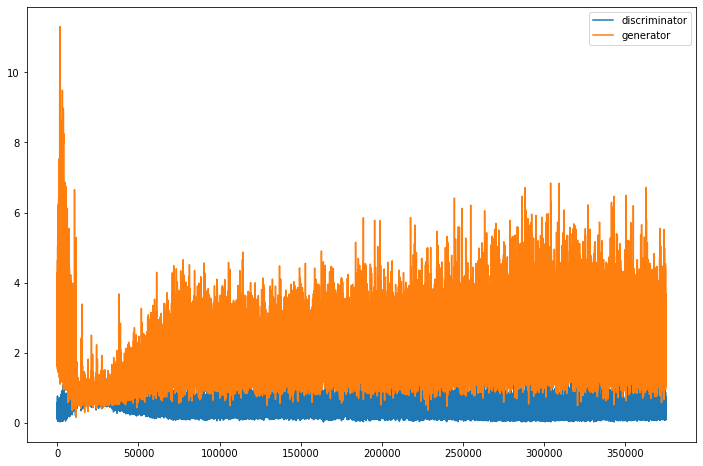

In [38]:
_ = plt.figure(figsize=(12,8))
plt.plot(d_losses,label = 'discriminator')
plt.plot(g_losses,label = 'generator')
plt.legend()
plt.show()